# Introduction

Recognizing traffic signs from real-time video streams from smart vehicles is one of the demanding solutions in today's automobile industry. It became a demanding solution in autonomous vehicles, driver assistance systems and mobile mapping. The Traffic Sign Recognition (TSR) challenge consists two components 1) traffic sign detection and traffic sign classification. Traffic sign detection is the activity of accurate localizing the traffic sign in an image, while traffic sign classification assigns a label (symbol name/details) to the localized picture. Recent developments in Deep Learning and publically available data sets such as Belgium and German Traffic Sign Data accelerated many innovations in this field. The objective of the current project is to build a traffic sign classification system with the German Traffic Signs dataset. 

## Exploratory Data Analysis

The dataset is supplied as Python pickled objects. The training, validation and test data are in the same format. Each picked object contains the following information: 'labels', 'coords', 'sizes', 'features'. The 'features' contain the image pixel data, 'coords' contains localization information, 'size' contains image size and the  'labels' contains a numeric value representing the traffic sign represented in the image. The train, test and valid data consist 34799, 12630, 4410 samples respectively. There are 43 traffic signs in this image data sets, and it translates to 43 labels in the data sets.

In [1]:
%matplotlib inline
from matplotlib import pylab as plt
import seaborn as sn
plt.rcParams['figure.figsize'] = (9,4)

In [2]:
import glob
import pickle
import random

import numpy as np
import pandas as pd
from skimage import exposure
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn import metrics

### Reading the Data

In [3]:
data_files = glob.glob("data/*.p")

In [4]:
train = None
test = None
valid = None

for fname in data_files:
    with open(fname,mode='rb') as pf:
        if fname.endswith("test.p"):
            test = pickle.load(pf)
        elif fname.endswith("train.p"):
            train = pickle.load(pf)
        elif fname.endswith("valid.p"):
            valid = pickle.load(pf)

#### Total records in Train Test and Valid Sets

In [5]:
len(train["features"]),len(test["features"]),len(valid["features"])

(34799, 12630, 4410)

### Class Distribution Analysis in the Data
An analysis of the class distribution in training data suggests that it is a highly imbalanced dataset. The well-represented class consists samples in the range of 1000 to 2500 and the under-represented classed consists instances in the range of 120 to 850. In general Machine Learning scenarios, the under-represented or imbalanced class distribution is not an ideal situation to start with any Machine Learning experiment. So it is recommended to perform either additional data collection or perform an oversampling or undersampling of the data. Oversampling of data is a typical strategy for the same. 

In [6]:
train_df = pd.Series(train['labels'])
train_label_count = train_df.value_counts()
test_df = pd.Series(test['labels'])
test_label_count = test_df.value_counts()
valid_df = pd.Series(valid['labels'])
valid_label_count = valid_df.value_counts()

In [7]:
train_label_count_df = pd.DataFrame()
train_label_count_df["ClassId"] = train_label_count.index
train_label_count_df["Count"] = train_label_count.values
label_map = pd.read_csv("signnames.csv")
train_joined_labels = pd.merge(train_label_count_df,label_map,on='ClassId')

In [8]:
sign_label_map = dict(zip(train_joined_labels.ClassId,train_joined_labels.SignName))

In [9]:
len(sign_label_map)

43

In [10]:
image_samples =[np.where(train["labels"]==i)[0][0] for i, x in enumerate(np.unique(train["labels"]))]

In [11]:
samples = [train["features"][img_indx] for indx,img_indx in enumerate(image_samples)]

In [12]:
def plot_one_sample(samples):
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(samples)):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(samples[i].squeeze())
    plt.show()

###### Sample Image from all the categories

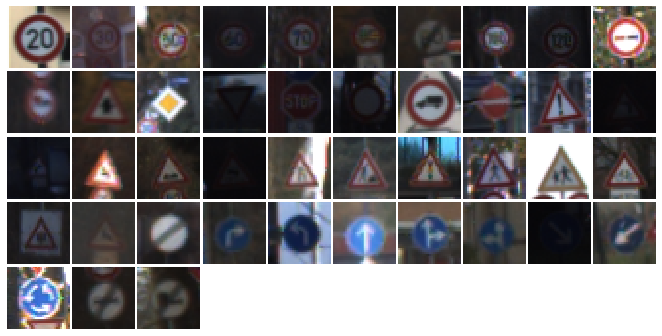

In [13]:
plot_one_sample(samples)

In [14]:
def plot_class_dict(train_label_count,color):

    train_label_count_df = pd.DataFrame()
    train_label_count_df["ClassId"] = train_label_count.index
    train_label_count_df["Count"] = train_label_count.values
    label_map = pd.read_csv("signnames.csv")
    train_joined_labels = pd.merge(train_label_count_df,label_map,on='ClassId')
    train_joined_labels.index = train_joined_labels.ClassId
    sbp = sn.barplot(x="SignName",y="Count",data=train_joined_labels,color=color)
    d = plt.setp(sbp.get_xticklabels(), rotation=90)
    plt.ylabel("Count")
    plt.show()

###### Training Data Class Distribution

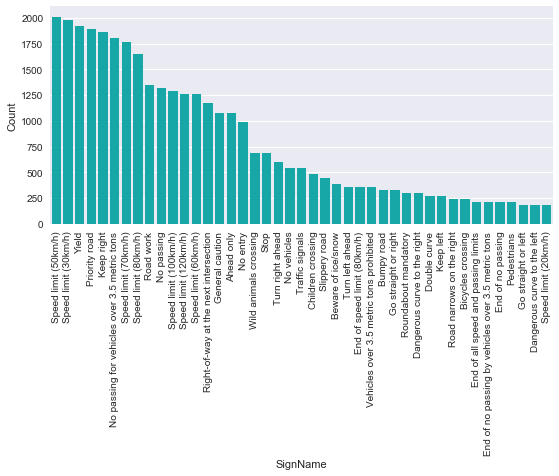

In [15]:
plot_class_dict(train_label_count,"c")

###### Test Data Class Distribution

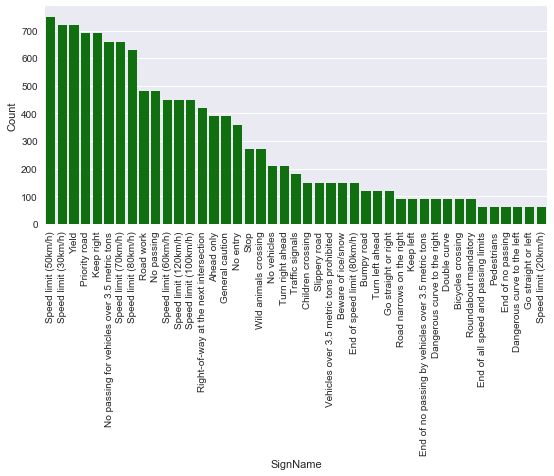

In [16]:
plot_class_dict(test_label_count,"g")

###### Validation Data Class Distribution

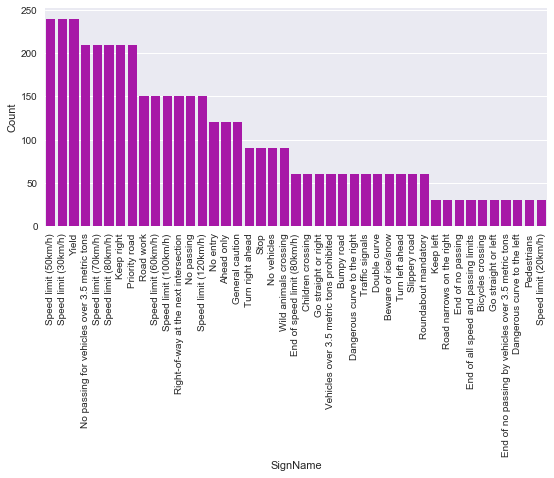

In [17]:
plot_class_dict(valid_label_count,"m")

### Synthetic Data Generation
The additional data generation to overcome the imbalanced data is performed with Keras library. Keras provided image augmentation API with a comprehensive set of parameters to satisfy different experiment purposes. The settings used in the current projects includes
* featurewise_center: Set input mean to 0 over the dataset, feature-wise.
* rotation_range:  Degree range for random rotations. The rotation range was specified as 17 for the augmentation.
* width_shift_range: Range for random horizontal shifts. Specified value 0.1
*  height_shift_range: Range for random vertical shifts. Specified value 0.1
* shear_range:  Shear Intensity (Shear angle in the counter-clockwise direction as radians). Specified Value: 0.3
* zoom_range: Range for random zoom. Specified Value: 0.15
* horizontal_flip:  Randomly flip inputs horizontally. Not performed 


In [18]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


augumentar = ImageDataGenerator(rotation_range=17,width_shift_range=0.1,\
height_shift_range=0.1,shear_range=0.3,zoom_range=0.15,horizontal_flip=False,\
fill_mode='nearest',featurewise_center=True)
#fill_mode='nearest',featurewise_center=True,zca_whitening=True)

def image_aug(X,y):
    """
    Apply image Augumentation with Keras
    """
    X_aug = None
    y_aug = None
    #augumentar.fit(X)
    for X_batch, y_batch in augumentar.flow(X, y, batch_size=X.shape[0], shuffle=False):
        X_aug = X_batch.astype('uint8')
        y_aug = y_batch
        break
    return (X_aug,y_aug)

Using TensorFlow backend.


In [19]:
augm_images = image_aug(train["features"],train["labels"])

/Users/jagan/anaconda2/envs/sdc/lib/python3.5/site-packages/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


###### A Sample Augumented Image

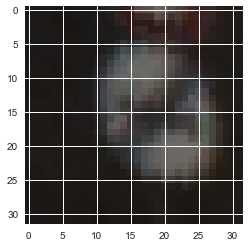

In [20]:
plt.imshow(augm_images[0][1].squeeze())

In [21]:
X_train_augumented = augm_images[0]
Y_train_augumented = augm_images[1]

###### Augumented Image sample from 43 categories

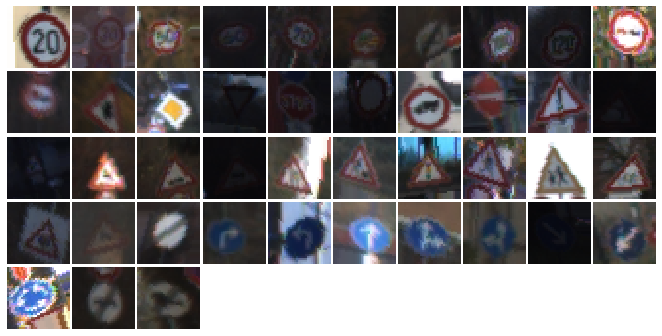

In [22]:
aug_samplees = [X_train_augumented[img_indx] for indx,img_indx in enumerate(image_samples)]
plot_one_sample(aug_samplees)

#### Motion Blur 

The additional image data generation step adopted in this project is Motion Blur. Motion blur is the apparent streaking of rapidly moving objects in a still image. It helps the traffic sign classifier to almost accurately classify a localized sign to the proper category. In real-time image processing, this techniques is a very useful approach. 

In [23]:
def mblur(X):
    """
    Create a motion blur
    """
    X_out = np.empty((X.shape)).astype('uint8')
    size = 4
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    for idx, img in enumerate(X):
        X_out[idx] = cv2.filter2D(img, -1, kernel_motion_blur)
    return X_out

In [24]:
X_train_motion_blur = mblur(train["features"])
y_train_motion_blur = train["labels"]

###### Sample Results of Motion Blur

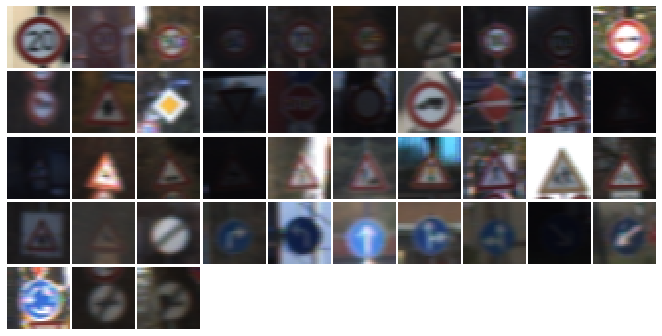

In [25]:
mb_samplees = [X_train_motion_blur[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

#### Preprocessing 
In this project, we preprocessed the images before it is being presented to the algorithm for model building. The preprocessing steps adopted in the projects are normalizing the exposure and converting the images to grayscale. This steps will help us preventing some of the adversarial scenarios, such as negative images are not getting classified correctly. Recent researched in the images processing, and Deep Learning reveals that negatives images will be a challenging one for many models. 

In [26]:
def process_image(img):
    img_c = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0]
    img_c = (img_c / 255.).astype(np.float32)
    img_c = (exposure.equalize_adapthist(img_c,) - 0.5)
    img_c = img_c.reshape(img_c.shape + (1,))
    return img_c

def preprocess_data(X):
    X_processed = np.empty((X.shape[0],X.shape[1],X.shape[2],1)).astype(np.float32) 
    for idx, img in enumerate(X):
        X_processed[idx] = process_image(img)
    return X_processed

In [27]:
X_train_raw_p = preprocess_data(train["features"])
y_train_raw_p = train["labels"]
X_train_aug_p = preprocess_data(X_train_augumented)
y_train_aug_p = Y_train_augumented
X_train_mb_p = preprocess_data(X_train_motion_blur)
y_train_mb_p = y_train_motion_blur

/Users/jagan/anaconda2/envs/sdc/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [28]:
X_test_raw_p = preprocess_data(test["features"])
y_test_raw_p = test["labels"]

X_valid_raw_p = preprocess_data(valid["features"])
y_valid_raw_p = valid["labels"]

/Users/jagan/anaconda2/envs/sdc/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


#### Preprocessed Raw Training Data Samples

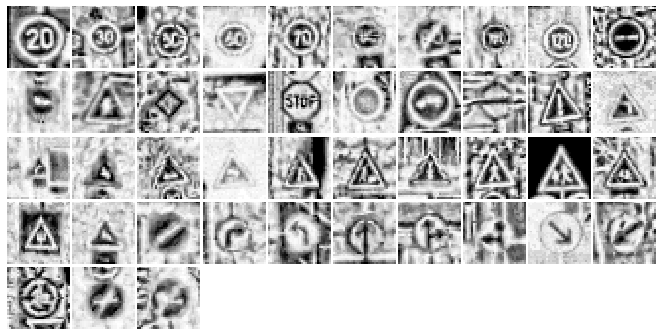

In [29]:
mb_samplees = [X_train_raw_p[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

##### Preprocessed Augumented Data

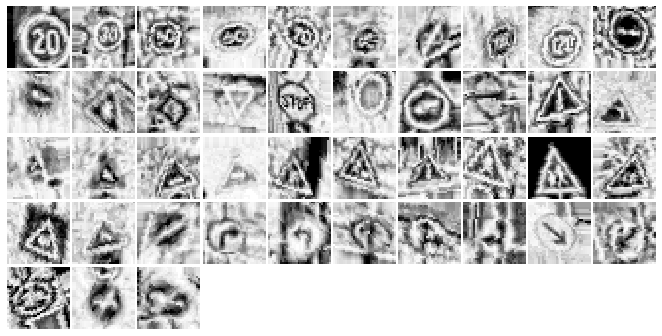

In [30]:
mb_samplees = [X_train_aug_p[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

In [31]:
X_train = np.concatenate((X_train_raw_p,X_train_aug_p,X_train_mb_p), axis=0)
y_train = np.concatenate((y_train_raw_p,y_train_aug_p,y_train_mb_p), axis=0)

In [32]:
X_train, y_train = shuffle(X_train, y_train)

## The Model
The current model is inspired by the LeNet and names as "ThirdEye." The Architecture has two convolution layer followed by a fully connected layer. RELU is used as activation function in all the three layers. Drop-out rate of 20,30 and 40 is specified in respective layers. 

In [33]:
import tensorflow as tf

n_classes = len(np.unique(train["labels"]))

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
apply_dropout = tf.placeholder(tf.bool)

In [34]:
EPOCHS = 10
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

In [35]:
def third_eye_net(X, w, b, dropout):
    #third_eye_net(x, weights, biases, apply_dropout):
    if dropout is not None:
        print ("Training")
    else:
        print ("Evalutation") 
        
    layer = 0
    
    """
    Layer 1: Convolutional. 
    Input = 32x32x1. 
    Output = 28x28x12.
    """
    conv1   = tf.nn.conv2d(X, w[layer], strides=[1, 1, 1, 1], padding='VALID') + b[layer]
    layer += 1

    """
    Activation.
    """
    conv1 = tf.nn.relu(conv1, name = 'eye1')

    """
    # Pooling. 
    Input = 28x28x12. 
    Output = 14x14x12.
    """
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    """
    Dropout
    """
    
    conv1 = tf.cond(apply_dropout, lambda: tf.nn.dropout(conv1, keep_prob = 0.8), lambda: conv1)

    """
    Layer 2: Convolutional. 
    Output = 10x10x24.
    """
    conv2   = tf.nn.conv2d(conv1, w[layer], strides=[1, 1, 1, 1], padding='VALID') +  b[layer]
    layer += 1
    
    """
    Activation.
    """
    conv2 = tf.nn.relu(conv2, name = 'eye2')

    """
    Pooling. 
    Input = 10x10x24. 
    Output = 5x5x24.
    """
    
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    """
    Dropout
    """
    
    conv2 = tf.cond(apply_dropout, lambda: tf.nn.dropout(conv2, keep_prob = 0.7), lambda: conv2)

    """
    Input = 14x14x12. 
    Output = 7x7x12 = 588
    """
    conv1_1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    shape = conv1_1.get_shape().as_list()
    conv1_1 = tf.reshape(conv1_1, [-1, shape[1] * shape[2] * shape[3]])    
    
    """
    Flatten conv2 Input = 5x5x24. Output = 600
    """
    shape = conv2.get_shape().as_list()
    conv2 = tf.reshape(conv2, [-1, shape[1] * shape[2] * shape[3]])
    
    fc0 = tf.concat([conv1_1, conv2],1)
    
    """
    Layer 3: Fully Connected. Input = 588+600 = 1188. Output = 320.
    """
    
    fc1   = tf.matmul(fc0, w[layer]) + b[layer]
    layer += 1
    
    """
    Activation.
    """
    
    fc1    = tf.nn.relu(fc1)
    
    """
    Dropout
    """
    
    fc1 = tf.cond(dropout, lambda: tf.nn.dropout(fc1, keep_prob = 0.6), lambda: fc1)
    logits = tf.matmul(fc1, w[layer]) + b[layer]
    
    return logits

#### Model Pipeline

In [36]:
rate = 0.001


mu = 0
sigma = 0.1
beta = 0.001


weights = [
    tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma)),
    tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 24), mean = mu, stddev = sigma)),
    tf.Variable(tf.truncated_normal(shape=(1188, 320), mean = mu, stddev = sigma)),
    tf.Variable(tf.truncated_normal(shape=(320, n_classes), mean = mu, stddev = sigma))
]
biases = [
   tf.Variable(tf.zeros(12)),
   tf.Variable(tf.zeros(24)),
   tf.Variable(tf.zeros(320)),
   tf.Variable(tf.zeros(n_classes))
]


logits = third_eye_net(x, weights, biases, apply_dropout)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

regularizer = tf.reduce_sum([tf.nn.l2_loss(w) for w in weights])
loss = tf.reduce_mean(loss_operation + beta * regularizer)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss)
#tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y)

Training


#### Model Evaluation 

In [37]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, apply_dropout: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training the Model

In [38]:
best_validation_accuracy = 0.0
train_accuracy = list()
valid_accuracy = list()

In [39]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, apply_dropout: True })
            
        validation_accuracy = evaluate(X_valid_raw_p, y_valid_raw_p)
        valid_accuracy.append(validation_accuracy)
        training_accuracy = evaluate(X_train, y_train)
        train_accuracy.append(training_accuracy)
        if (validation_accuracy > best_validation_accuracy):
            best_validation_accuracy = validation_accuracy
            saver.save(sess, './tenet')
            print("Model saved")

Model saved
Model saved
Model saved
Model saved
Model saved


### Model Perfromance in Validation and Training Data

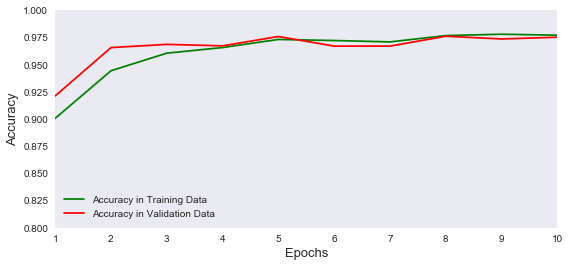

In [40]:
px = list(range(1,11))
plt.plot(px,train_accuracy,'-g',label="Accuracy in Training Data")
plt.plot(px,valid_accuracy,'-r',label="Accuracy in Validation Data")
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.legend()
plt.xlim(1,10)
plt.ylim(0.8,1.0)
plt.grid(False)

### Model Evaluation Results
During the training phase, the model performance was very satisfactory and resulted in about 97% accuracy in the validation data. The evaluation results in training, validation and test data are: 
* Training Accuracy = 0.972
* Validation Accuracy = 0.978
* Test Accuracy = 0.965

The evaluation results in Test Data is 
* test accuracy: 0.964845605625
* Precision 0.95536102367
* Recall 0.964845605701
* f1_score 0.964505652242

In [41]:
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, './tenet')

    training_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(training_accuracy))
    validation_accuracy = evaluate(X_valid_raw_p, y_valid_raw_p)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

    test_accuracy = evaluate(X_test_raw_p, y_test_raw_p)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    #metrics
    y_p = tf.argmax(logits, 1)
    y_pred = sess.run( y_p, feed_dict={x: X_test_raw_p, y: y_test_raw_p, apply_dropout: False})

Training Accuracy = 0.977
Validation Accuracy = 0.976
Test Accuracy = 0.965


In [42]:
from sklearn import metrics
     
print ("test accuracy:", test_accuracy)
y_true = y_test_raw_p
print ("Precision", metrics.precision_score(y_true, y_pred, average='macro'))
print ("Recall", metrics.recall_score(y_true, y_pred, average='micro'))
print ("f1_score", metrics.f1_score(y_true, y_pred, average='weighted'))
print ("Confusion_matrix")
cm = metrics.confusion_matrix(y_true, y_pred)

test accuracy: 0.96468725246
Precision 0.954027285369
Recall 0.964687252573
f1_score 0.964293014987
Confusion_matrix


#### Model Results - Confusion Matrix

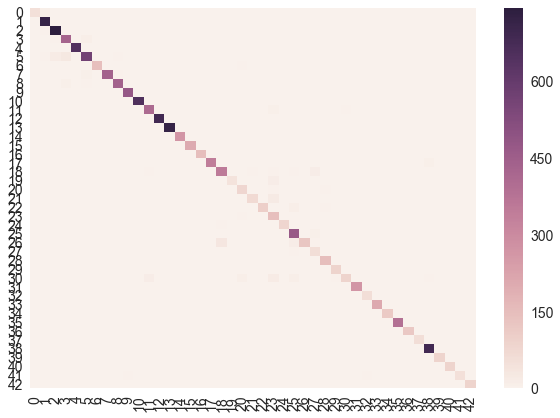

In [43]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(cm,annot=False,annot_kws={"size": 10})

## Test Model on New Images
A set of 38 random images of traffic signs were extracted from various web resources and used for the model evaluation. In this data, the model showed a performance of 71% accuracy. 

In [44]:
x_test_ext = None
with open("data/gd_new_test.p","rb") as testf:
    x_test_ext = pickle.load(testf)

In [45]:
y_custom = np.array([21,39,17,17,17,39,39, 40,40,34,28,39,0,17,38,\
13,40,13,38,38,11,0,28,0, 99, 99, 99, 32, 40,28, 40,40,28,24, 0, 0, \
0,0 ])

In [46]:
len(y_custom)

38

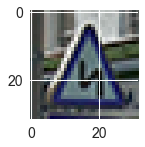

In [47]:
plt.figure(figsize=(2,2))
plt.imshow(x_test_ext["test_new"][0].squeeze())

In [48]:
X_new_test = preprocess_data(np.array(x_test_ext["test_new"]))

/Users/jagan/anaconda2/envs/sdc/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


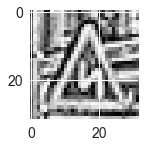

In [49]:
plt.figure(figsize=(2,2))
plt.imshow(X_new_test[0].squeeze())

In [50]:
with tf.Session() as sess:
    saver.restore(sess, './tenet')
    
    test_accuracy = evaluate(X_new_test, y_custom)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.579


### Softmax Probabilities For Each Image Found on the Web

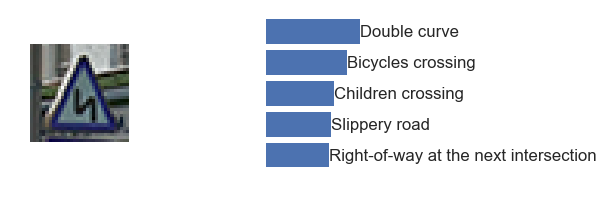

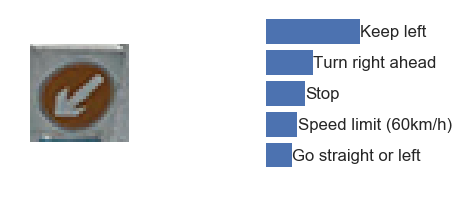

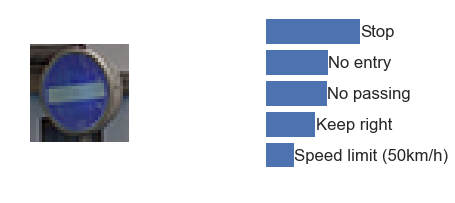

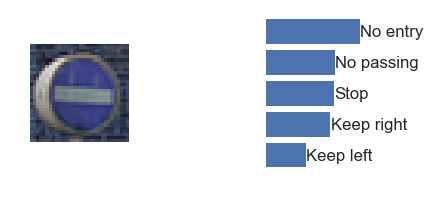

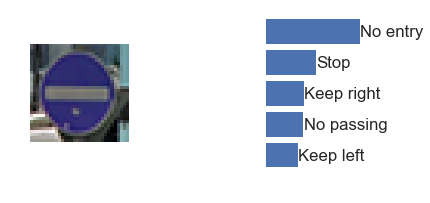

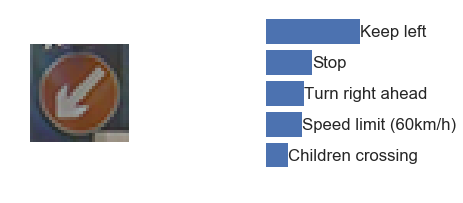

In [51]:
#sign_label_map

import matplotlib.gridspec as gridspec

feed_dict_new = feed_dict={x: X_new_test, y: y_custom, apply_dropout: False}
with tf.Session() as sess:
    saver.restore(sess, './tenet')
    predictions = sess.run(logits,feed_dict = feed_dict_new)
    top5_pred = sess.run([logits, tf.nn.top_k(logits, 5)], feed_dict=feed_dict_new)


    
for i in range(6):
    plt.figure(figsize = (6,3))
    gs = gridspec.GridSpec(1, 3)
    plt.subplot(gs[0])
    plt.axis('off')
    plt.imshow((x_test_ext["test_new"][i].squeeze()))
    plt.subplot(gs[1])
    plt.axis('off')
    plt.subplot(gs[2])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.15,
            sign_label_map[top5_pred[1][1][i][i_label]])
    plt.axis('off');

    plt.show();    

In [52]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, apply_dropout: False})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) 
        plt.title('FeatureMap ' + str(featuremap))
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", \
            vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", \
            vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", \
            vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", \
            cmap="gray")

## Visualize the Neural Network's State with Test Images
The code for the same is adapted from Udacity's training materials and the sample notebook

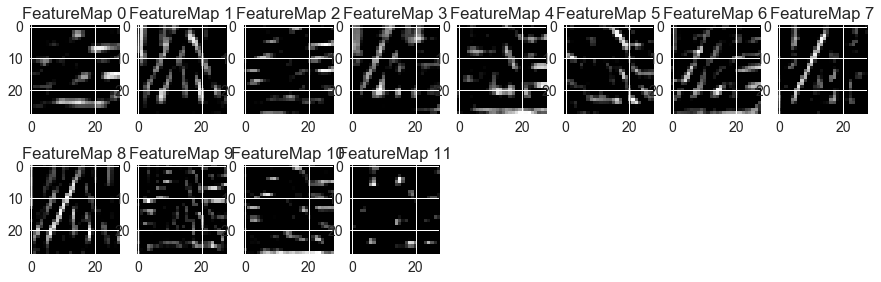

In [53]:
with tf.Session() as sess:
    saver.restore(sess, './tenet')
    act1 = tf.get_default_graph().get_tensor_by_name("eye1:0")
    outputFeatureMap(X_new_test, act1)

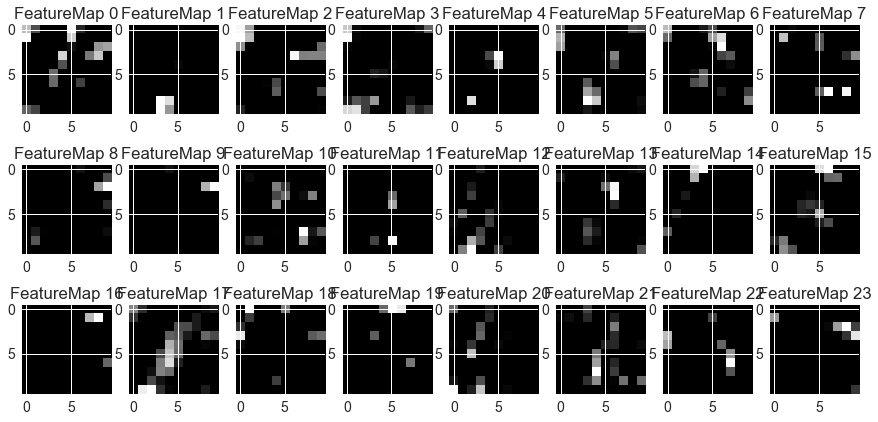

In [54]:
with tf.Session() as sess:
    saver.restore(sess, './tenet')
    act1 = tf.get_default_graph().get_tensor_by_name("eye2:0")
    outputFeatureMap(X_new_test, act1)

### Bonus Step : Softmax Probabilities in Random Images Picked from Belgium Data

In [55]:
belgium_data = None
with open("data/belg_data.p","rb") as testf:
    belgium_data = pickle.load(testf)

In [56]:
X_belgium = belgium_data["belg_data"]

In [57]:
X_belg_pp = preprocess_data(np.array(X_belgium))

/Users/jagan/anaconda2/envs/sdc/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


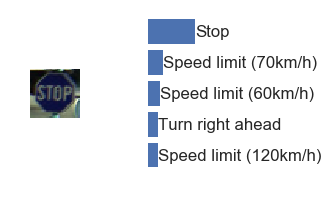

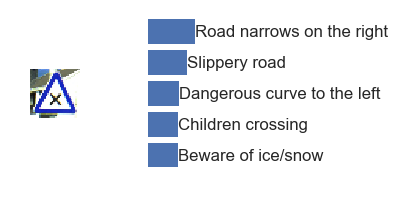

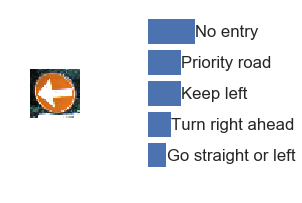

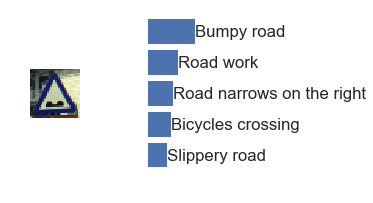

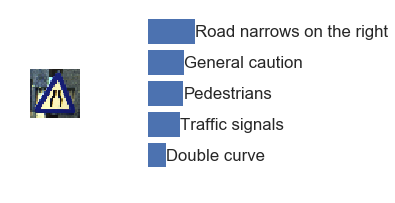

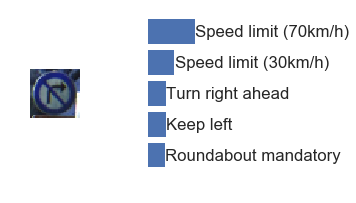

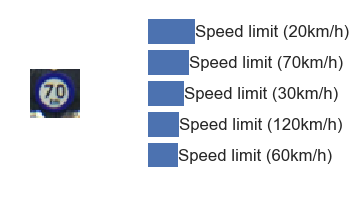

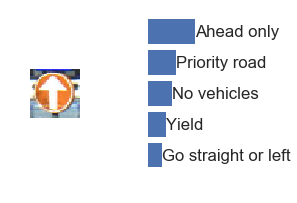

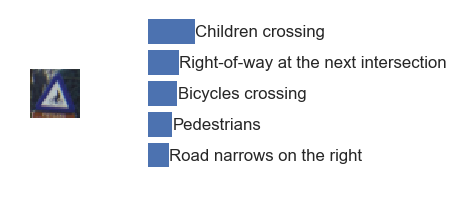

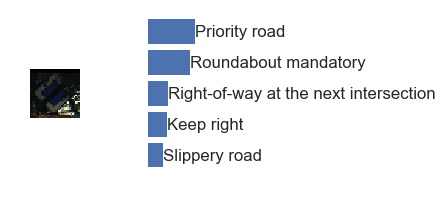

In [58]:
import matplotlib.gridspec as gridspec

feed_dict_new = feed_dict={x: X_belg_pp, apply_dropout: False}
with tf.Session() as sess:
    saver.restore(sess, './tenet')
    predictions = sess.run(logits,feed_dict = feed_dict_new)
    top5_pred = sess.run([logits, tf.nn.top_k(logits, 5)], feed_dict=feed_dict_new)


    
for i in range(10):
    #plt.figure(figsize = (10,3))
    #plt.figure(figsize=(9, 9))
    plt.figure(figsize=(3,3))
    gs = gridspec.GridSpec(1, 3)
    plt.subplot(gs[0])
    plt.axis('off')
    plt.imshow((X_belgium[i].squeeze()))
    plt.subplot(gs[1])
    plt.axis('off')
    plt.subplot(gs[2])
    plt.barh(6-np.arange(5),top5_pred[1][0][i], align='center')
    for i_label in range(5):
        plt.text(top5_pred[1][0][i][i_label]+.02,6-i_label-.15,
            sign_label_map[top5_pred[1][1][i][i_label]])
    plt.axis('off');

    plt.show();